1.如何在scipy中使用函数插值模块：interpolate；
2.动率曲面构造的原理；
3.将interpolate运用于波动率曲面构造。

# 1. 如何使用scipy做函数插值 （interpolation）

In [61]:
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')
dir(interpolate)[:5]

['Akima1DInterpolator',
 'BPoly',
 'BSpline',
 'BarycentricInterpolator',
 'BivariateSpline']

Spline Interpolation: fits low-degree polynomials （多项式） to small subsets of the values.

For example, fitting nine cubic polynomials between each of the pairs of ten points, instead of fitting a single degree-nine polynomial to all of them. 

Pro: 
- Spline interpolation is often preferred over polynomial interpolation because the interpolation error can be made small even when using low-degree polynomials for the spline.
- Avoid Runge's phenomenon

作为介绍性质的本篇，我们将只关注interpolate.spline的使用，即样条插值方法：

- xk离散的自变量值，为序列
- yk对应xk的函数值，为与xk长度相同的序列
- xnew需要进行插值的自变量值序列
- order样条插值使用的函数基德阶数，为1时使用线性函数

scipy.interpolate.make_interp_spline(x, y, k=3, t=None, bc_type=None, axis=0, check_finite=True)[source]

## 1.1 三角函数（np.sin）插值


Text(0.5, 1.0, '$f(x)$discrete plot')

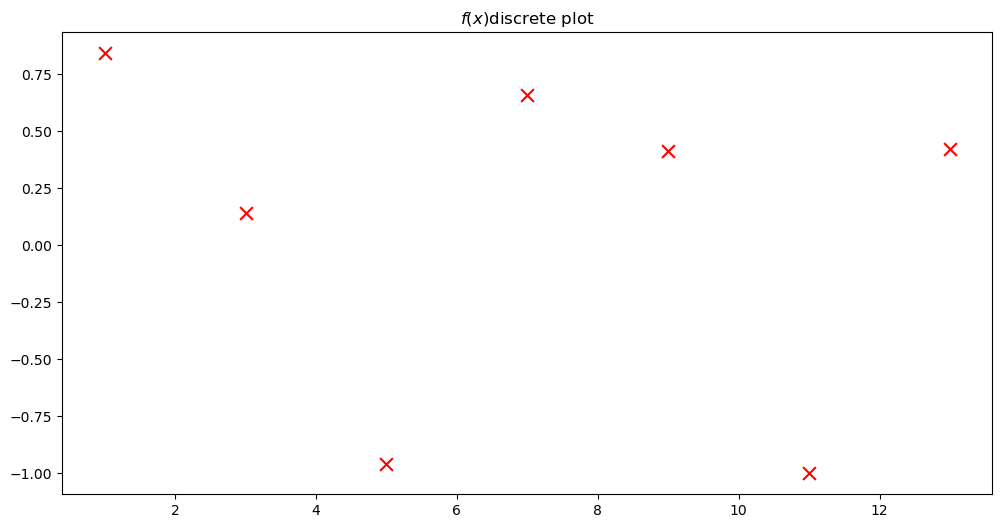

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
x = np.linspace(1.0, 13.0, 7)
y = np.sin(x)
pylab.figure(figsize = (12,6))
pylab.scatter(x,y, s = 85, marker='x', color = 'r')
pylab.title(u'$f(x)$discrete plot')

In [83]:
xnew = np.linspace(1.0,13.0,500)

ynewLinear = interpolate.make_interp_spline(x,y,k=1)
y_newlinear = ynewLinear(xnew).T


ynewcubic = interpolate.make_interp_spline(x,y,k=3)
y_newcubic = ynewcubic(xnew).T

y_real = np.sin(xnew)

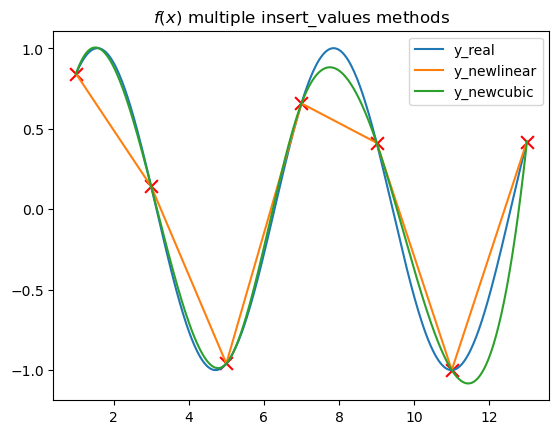

In [85]:
pylab.plot(xnew, y_real)
pylab.plot(xnew, y_newlinear)
pylab.plot(xnew, y_newcubic)
pylab.scatter(x,y, s = 85, marker='x', color = 'r')
pylab.legend(['y_real','y_newlinear','y_newcubic'])
pylab.title('$f(x)$ multiple insert_values methods', fontsize =12)
pylab.show()

# 2. 函数插值应用 —— 期权波动率曲面构造


市场上期权价格一般以隐含波动率的形式报出，一般来讲在市场交易时间，交易员可以看到类似的波动率矩阵（Volatilitie Matrix): 交易员可以看到市场上离散值的信息，但是如果可以获得一些隐含的信息更好：例如，在2015年6月25日以及2015年9月25日之间，波动率的形状会是怎么样的？ 我们可以通过方差曲面插值构造“期权波动率曲面"

In [91]:
import pandas as pd
from datetime import datetime
from datetime import date as date
from datetime import  timedelta
pd.options.display.float_format = '{:.2f}'.format
dates = [date(2015,3,25), date(2015,4,25), date(2015,6,25), date(2015,9,25)]
strikes = [2.2, 2.3, 2.4, 2.5, 2.6]
blackVolMatrix = np.array([[ 0.32562851,  0.29746885,  0.29260648,  0.27679993],
                  [ 0.28841840,  0.29196629,  0.27385023,  0.26511898],
                  [ 0.27659511,  0.27350773,  0.25887604,  0.25283775],
                  [ 0.26969754,  0.25565971,  0.25803327,  0.25407669],
                  [ 0.27773032,  0.24823248,  0.27340796,  0.24814975]])
table = pd.DataFrame(blackVolMatrix * 100, index = strikes, columns = dates, )
table.index.name = 'Strike'
table.columns.name = 'Expiry'
print('2015-03-03 10:00 Volatility Matrix')
table

2015-03-03 10:00 Volatility Matrix


Expiry,2015-03-25,2015-04-25,2015-06-25,2015-09-25
Strike,,,,
2.20,32.56,29.75,29.26,27.68
2.30,28.84,29.20,27.39,26.51
2.40,27.66,27.35,25.89,25.28
2.50,26.97,25.57,25.80,25.41
2.60,27.77,24.82,27.34,24.81


# 2.1 方差曲面插值

我们并不是直接在波动率上进行插值，而是在方差矩阵上面进行插值。方差和波动率的关系如下：

所以下面我们将通过处理，获取方差矩阵（Variance Matrix):
    VaR = sigma * t^2

In [93]:
evaluationDate = date(2015,3,3)
ttm = np.array([(d - evaluationDate) / 365.0 for d in dates])
ttm = ttm/timedelta(days=1)  
varianceMatrix = (blackVolMatrix**2) * ttm
varianceMatrix

array([[0.006391085982469228, 0.012848901332342776, 0.026741136831691503,
        0.043242053307068894],
       [0.005013900866114099, 0.01237794155734418, 0.023422767467278935,
        0.039669433294732576],
       [0.004611251526876472, 0.01086231055809625, 0.02093127579639813,
        0.03607930721083693],
       [0.004384133665323341, 0.009490904186056493, 0.020795214248051065,
        0.0364337607306079],
       [0.004649180477481717, 0.008947469311828823, 0.023347172699376625,
        0.03475377938508424]], dtype=object)

下面我们将在行权价方向以及时间方向同时进行线性插值
这个过程在scipy中可以直接通过interpolate模块下interp2d来实现：

- ttm 时间方向离散点
- strikes 行权价方向离散点
- varianceMatrix 方差矩阵，列对应时间维度；行对应行权价维度
- kind = 'linear' 指示插值以线性方式进行

In [95]:
interp = interpolate.RegularGridInterpolator((ttm, strikes), varianceMatrix.T, method = 'cubic')

In [96]:
interp((ttm[0], strikes[0]))

array(0.00639109)

In [97]:
sMeshes = np.linspace(strikes[0], strikes[-1], 400)
tMeshes = np.linspace(ttm[0], ttm[-1], 200)
interpolatedVarianceSurface = np.zeros((len(sMeshes), len(tMeshes)))
for i, s in enumerate(sMeshes):
    for j, t in enumerate(tMeshes):
        interpolatedVarianceSurface[i][j] = interp((t,s))

interpolatedVolatilitySurface = np.sqrt((interpolatedVarianceSurface / tMeshes))
print('Strike Grid Count：', np.size(interpolatedVolatilitySurface, 0))
print('Maturity Grid Count：', np.size(interpolatedVolatilitySurface, 1))

Strike Grid Count： 400
Maturity Grid Count： 200


Text(0.5, 1.0, 'Option volatility, Expiry Date: 2015-03-25')

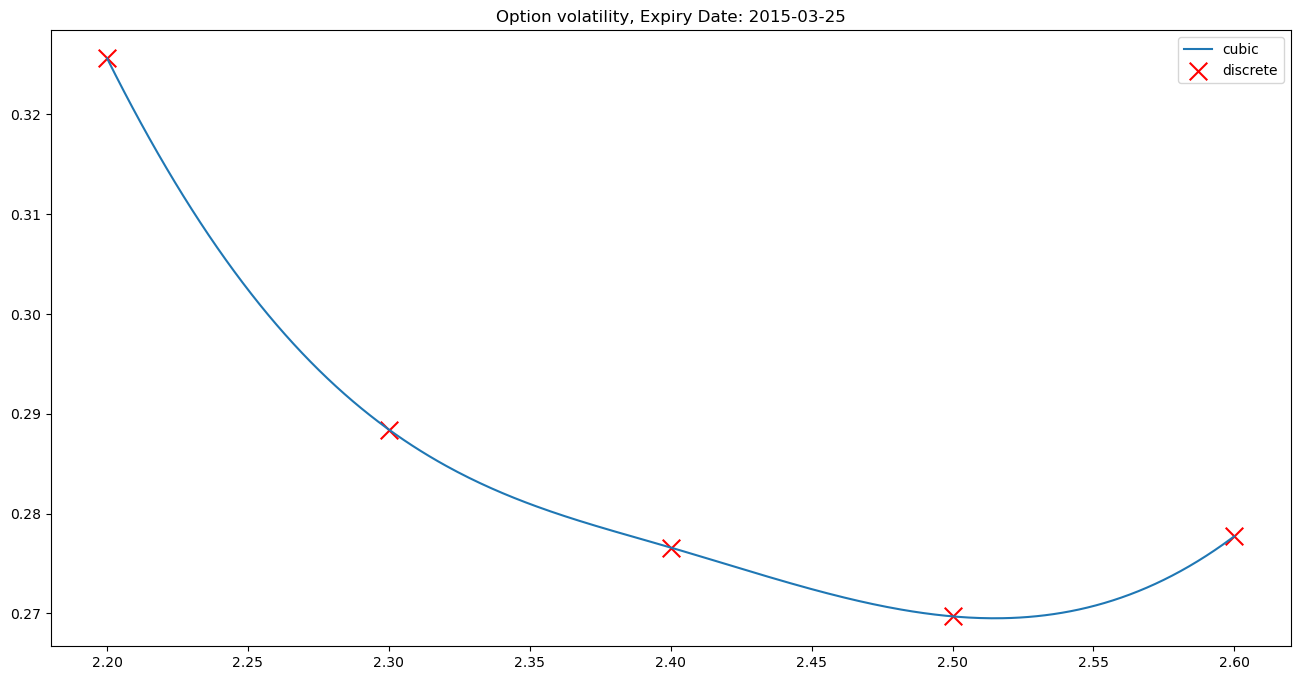

In [98]:
pylab.figure(figsize = (16,8))
pylab.plot(sMeshes, interpolatedVolatilitySurface[:, 0])
pylab.scatter(x = strikes, y = blackVolMatrix[:,0], s = 160,marker = 'x', color = 'r')
pylab.legend([u'cubic', u'discrete'])
pylab.title(u'Option volatility, Expiry Date: 2015-03-25')

Text(0.5, 0, 'volatility(%)')

<Figure size 1600x900 with 0 Axes>

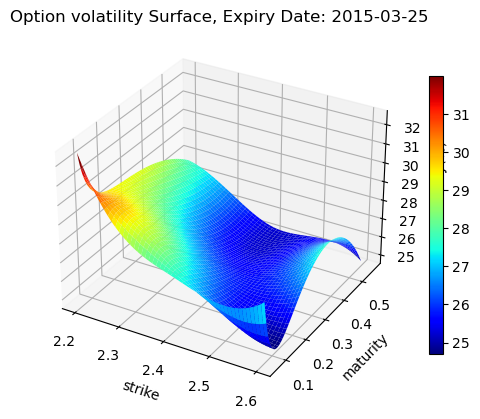

In [101]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

maturityMesher, strikeMesher = np.meshgrid(tMeshes, sMeshes)
pylab.figure(figsize = (16,9))
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
surface = ax.plot_surface(strikeMesher, maturityMesher, interpolatedVolatilitySurface*100, cmap = cm.jet)
pylab.colorbar(surface,shrink=0.75)
pylab.title('Option volatility Surface, Expiry Date: 2015-03-25')
pylab.xlabel("strike")
pylab.ylabel("maturity")
ax.set_zlabel(r"volatility(%)")